### Import Packages

In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
import torchsummary
from alive_progress import alive_bar

### Global attributes

In [2]:
mixed_dir = {
    'machine': '../machine/mixed/',
    'nature': '../nature/mixed/',
    'human': '../human/mixed/'
}

clean_dir = {
    'machine': '../machine/clean/',
    'nature': '../nature/clean/',
    'human': '../human/clean/'
}

# TODO
test_dir = {
    'input': '../classification_data/machine_output/',
    'output': '../test_output/machine/',
    'visual': '../visualization/machine/'
}

### SNR

In [3]:
def calculate_snr(clean_signal, denoised_signal):
    """
    Calculate the Signal-to-Noise Ratio (SNR) in decibels.
    
    Args:
    clean_signal (torch.Tensor): Ground truth clean signal, shape (1, 1, H, W)
    denoised_signal (torch.Tensor): Model's output signal, shape (1, 1, H, W)
    
    Returns:
    float: SNR value in decibels.
    """
    assert clean_signal.shape == denoised_signal.shape, "Shapes of input tensors must match."
    clean_signal = clean_signal.squeeze()
    denoised_signal = denoised_signal.squeeze()
    signal_power = torch.mean(clean_signal ** 2)
    noise_power = torch.mean((clean_signal - denoised_signal) ** 2)
    if noise_power == 0:
        return float('inf')
    snr = 10 * torch.log10(signal_power / noise_power)
    return snr.item()

### Preprocess Data

In [4]:
# MelSpectrogram參數
n_mels = 128                # 保持 Mel 頻譜圖的解析度
n_fft = 1024                # 提高 FFT 窗口大小以適配更多信號頻率
hop_length = 512            # 保持 hop_length 為 n_fft 的一半
win_length = 1024           # 窗口大小與 n_fft 保持一致（或設為 None 使用默認值）
sample_rate = 16000         # 採樣率保持不變，適合語音處理
f_max = sample_rate // 2    # 預設為 Nyquist 頻率，即 8000 Hz
duration = 5                # 音頻時長為 5 秒

In [5]:
def load_spectrogram_from_npy(mixed_dir, clean_dir = None):
    """Load mel spectrogram from a NumPy file."""
    mixed_mel_spectrograms = []
    clean_mel_spectrograms = []
    
    length = len(os.listdir(mixed_dir))
    
    print(f"Loading {length} files...")

    with alive_bar(length, force_tty=True) as bar:
        for filename in sorted(os.listdir(mixed_dir)):
            if ".gitkeep" in filename:
                continue
            try:
                # 使用完整路徑
                mixed_path = os.path.join(mixed_dir, filename)
                if (clean_dir != None): clean_path = os.path.join(clean_dir, filename)
                
                mixed_mel_spectrogram_db = np.load(mixed_path)
                if (clean_dir != None): clean_mel_spectrogram_db = np.load(clean_path)

                # # 轉換為 PyTorch tensor 並添加通道維度
                mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
                if (clean_dir != None): clean_mel_tensor = torch.tensor(clean_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
                
                mixed_mel_spectrograms.append(mixed_mel_tensor)
                if (clean_dir != None): clean_mel_spectrograms.append(clean_mel_tensor)
                
                bar()
                
            except Exception as e:
                print(f"Error load file {filename}: {str(e)}")
                continue

    if (clean_dir != None): return mixed_mel_spectrograms, clean_mel_spectrograms
    else: return mixed_mel_spectrograms

In [6]:
# TODO
machine_mixed_mel_spectrograms, machine_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['machine'], clean_dir['machine'])
# nature_mixed_mel_spectrograms, nature_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['nature'], clean_dir['nature'])
# human_mixed_mel_spectrograms, human_clean_mel_spectrograms = load_spectrogram_from_npy(mixed_dir['human'], clean_dir['human'])
test_mixed_mel_spectrograms = load_spectrogram_from_npy(test_dir['input'])
mixed_mel_spectrograms = machine_mixed_mel_spectrograms
clean_mel_spectrograms = machine_clean_mel_spectrograms
target_dim = 160
pad_width = [(0, 0), (0, 0), (0, target_dim - mixed_mel_spectrograms[0].shape[2])]
mixed_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in mixed_mel_spectrograms]
clean_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in clean_mel_spectrograms]
test_mixed_mel_spectrograms = [np.pad(i, pad_width=pad_width, mode='constant', constant_values=0) for i in test_mixed_mel_spectrograms]
mixed_mel_spectrograms_train, mixed_mel_spectrograms_val, clean_mel_spectrograms_train, clean_mel_spectrograms_val = train_test_split(mixed_mel_spectrograms, clean_mel_spectrograms, test_size=0.2, random_state=42)
time_steps = mixed_mel_spectrograms[0].shape[2]

Loading 7500 files...
|████████████████████████████████████████| 7500/7500 [100%] in 25.8s (291.78/s)  ▂▂▄ 2375/7500 [32%] in 1s (~2s, 2277. ▇▇▅ 5019/7500 [67%] in 2s (~1s, 2311. ▃▁▃ 5966/7500 [80%] in 5s (~1s, 1216.
Loading 20 files...
|████████████████████████████████████████| 20/20 [100%] in 0.1s (177.96/s)      


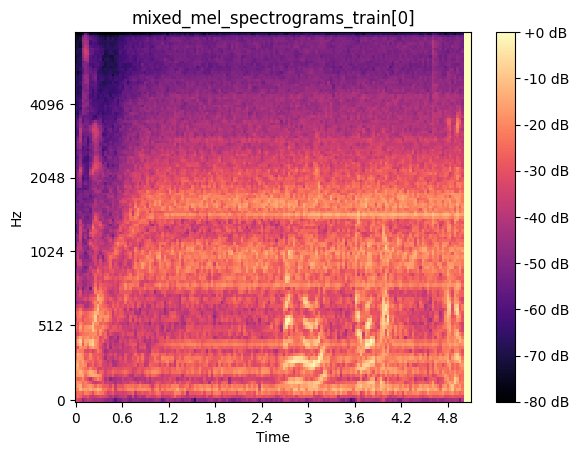

In [7]:
fig, ax = plt.subplots()
img = librosa.display.specshow(mixed_mel_spectrograms_train[0][0], sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='mixed_mel_spectrograms_train[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "mixed_mel_spectrograms_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

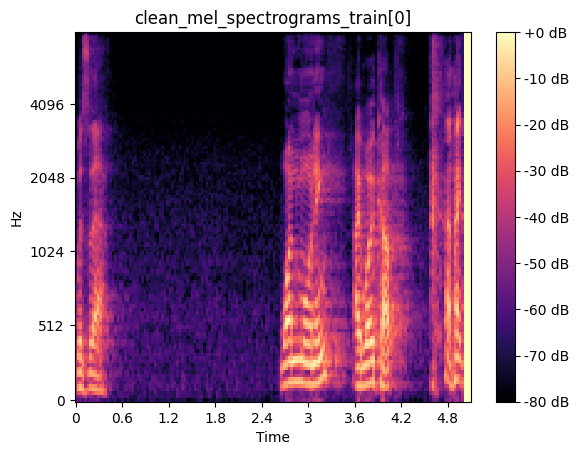

In [8]:
fig, ax = plt.subplots()
img = librosa.display.specshow(clean_mel_spectrograms_train[0][0], sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='clean_mel_spectrograms_train[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "clean_mel_spectrograms_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

### Training

In [9]:
class DenoiseAutoencoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoencoder, self).__init__()
        # 編碼器
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # 全連接層 ### shape 有問題
        self.fc1 = nn.Linear(10240, 256)  # 假設輸入大小為 (1, 64, 64)
        self.fc2 = nn.Linear(256, 10240)

        # 解碼器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        # 編碼器
        x = self.encoder(x)
        
        # 將特徵展平
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        
        # 全連接層處理
        x = self.fc1(x)
        x = self.fc2(x)
        
        # 恢復形狀為解碼器輸入
        x = x.view(batch_size, 128, 8, 10)
        # 解碼器
        x = self.decoder(x)
        return x

In [10]:
# Model參數
num_epochs = 100
batch_size = 256
learning_rate = 0.5
lr_decay_step = 20
lr_decay_gamma = 0.7

In [11]:
class AudioDataset(Dataset):
    def __init__(self, mixed_data, clean_data):
        self.mixed = mixed_data
        self.clean = clean_data
    
    def __len__(self):
        return len(self.mixed)
    
    def __getitem__(self, idx):
        return self.mixed[idx], self.clean[idx]

dataset = AudioDataset(mixed_mel_spectrograms_train, clean_mel_spectrograms_train)
dataloader = DataLoader(dataset, batch_size=batch_size)
dataloader_val = DataLoader(AudioDataset(mixed_mel_spectrograms_val, clean_mel_spectrograms_val), batch_size=len(mixed_mel_spectrograms_val))


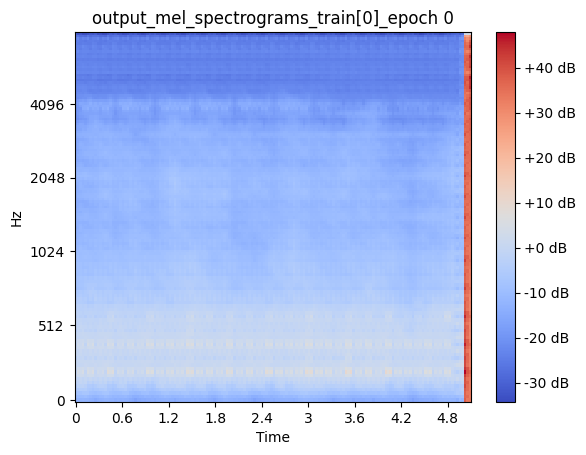

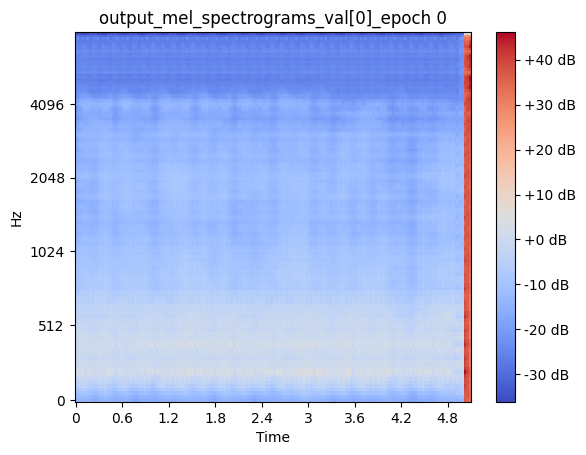

Epoch [1/100], Training Loss: 1917.751831054688, Validation Loss: 1992.671264648438, Learning Rate: 0.50000000
Epoch [2/100], Training Loss: 1139.689453125000, Validation Loss: 1205.537353515625, Learning Rate: 0.50000000
Epoch [3/100], Training Loss: 663.120361328125, Validation Loss: 724.869506835938, Learning Rate: 0.50000000
Epoch [4/100], Training Loss: 399.245666503906, Validation Loss: 462.144927978516, Learning Rate: 0.50000000
Epoch [5/100], Training Loss: 266.086791992188, Validation Loss: 310.804626464844, Learning Rate: 0.50000000
Epoch [6/100], Training Loss: 197.059844970703, Validation Loss: 235.051635742188, Learning Rate: 0.50000000
Epoch [7/100], Training Loss: 158.690841674805, Validation Loss: 163.783676147461, Learning Rate: 0.50000000
Epoch [8/100], Training Loss: 134.438995361328, Validation Loss: 143.744857788086, Learning Rate: 0.50000000
Epoch [9/100], Training Loss: 119.182548522949, Validation Loss: 132.525070190430, Learning Rate: 0.50000000
Epoch [10/100],

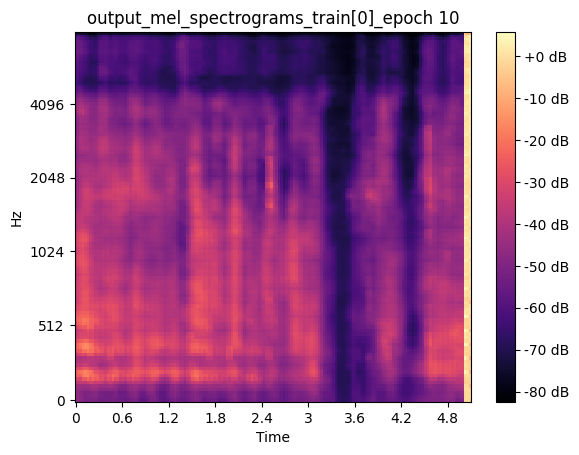

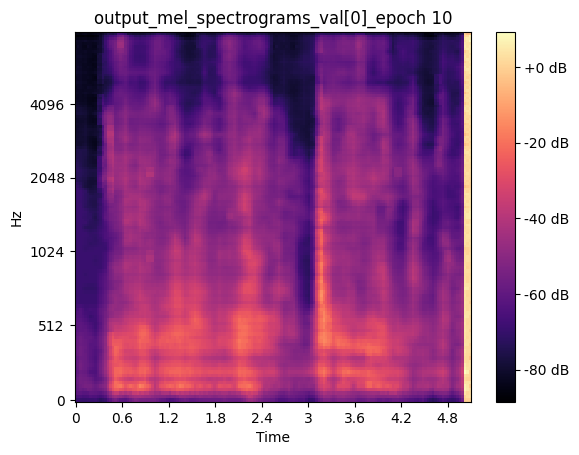

Epoch [11/100], Training Loss: 91.315902709961, Validation Loss: 110.785522460938, Learning Rate: 0.50000000
Epoch [12/100], Training Loss: 76.213546752930, Validation Loss: 129.500747680664, Learning Rate: 0.50000000
Epoch [13/100], Training Loss: 64.039718627930, Validation Loss: 139.752899169922, Learning Rate: 0.50000000
Epoch [14/100], Training Loss: 54.725067138672, Validation Loss: 133.236724853516, Learning Rate: 0.50000000
Epoch [15/100], Training Loss: 47.710483551025, Validation Loss: 136.776931762695, Learning Rate: 0.50000000
Epoch [16/100], Training Loss: 42.508880615234, Validation Loss: 130.725448608398, Learning Rate: 0.50000000
Epoch [17/100], Training Loss: 39.134529113770, Validation Loss: 127.049659729004, Learning Rate: 0.50000000
Epoch [18/100], Training Loss: 36.110996246338, Validation Loss: 108.364280700684, Learning Rate: 0.50000000
Epoch [19/100], Training Loss: 33.947479248047, Validation Loss: 107.644088745117, Learning Rate: 0.50000000
Epoch [20/100], Tra

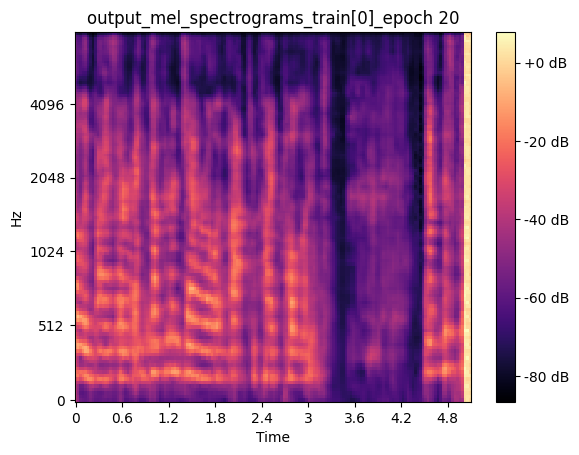

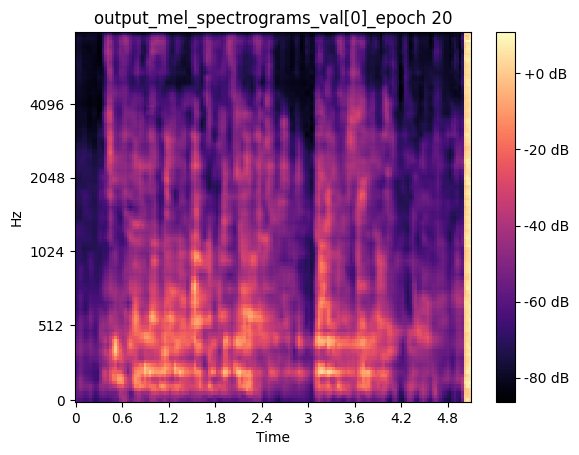

Epoch [21/100], Training Loss: 30.252222061157, Validation Loss: 84.829917907715, Learning Rate: 0.35000000
Epoch [22/100], Training Loss: 29.003787994385, Validation Loss: 86.500434875488, Learning Rate: 0.35000000
Epoch [23/100], Training Loss: 27.887813568115, Validation Loss: 94.398048400879, Learning Rate: 0.35000000
Epoch [24/100], Training Loss: 27.024309158325, Validation Loss: 96.491310119629, Learning Rate: 0.35000000
Epoch [25/100], Training Loss: 25.933921813965, Validation Loss: 91.319808959961, Learning Rate: 0.35000000
Epoch [26/100], Training Loss: 24.953674316406, Validation Loss: 86.392257690430, Learning Rate: 0.35000000
Epoch [27/100], Training Loss: 24.140808105469, Validation Loss: 83.388679504395, Learning Rate: 0.35000000
Epoch [28/100], Training Loss: 23.418901443481, Validation Loss: 79.791198730469, Learning Rate: 0.35000000
Epoch [29/100], Training Loss: 22.741838455200, Validation Loss: 76.396713256836, Learning Rate: 0.35000000
Epoch [30/100], Training Los

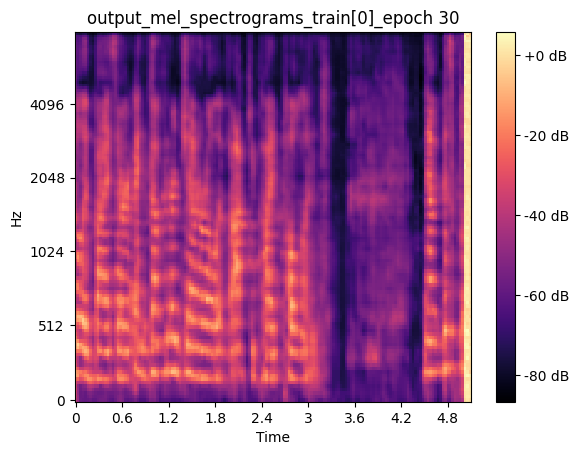

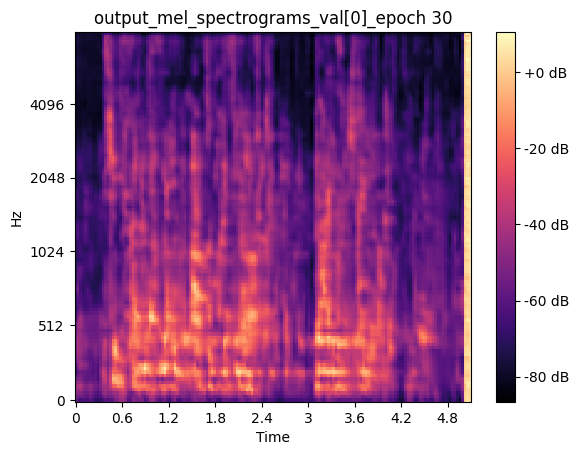

Epoch [31/100], Training Loss: 21.737514495850, Validation Loss: 75.345291137695, Learning Rate: 0.35000000
Epoch [32/100], Training Loss: 21.183542251587, Validation Loss: 75.841285705566, Learning Rate: 0.35000000
Epoch [33/100], Training Loss: 20.760772705078, Validation Loss: 71.910568237305, Learning Rate: 0.35000000
Epoch [34/100], Training Loss: 20.116638183594, Validation Loss: 70.737197875977, Learning Rate: 0.35000000
Epoch [35/100], Training Loss: 19.677080154419, Validation Loss: 70.936454772949, Learning Rate: 0.35000000
Epoch [36/100], Training Loss: 19.255933761597, Validation Loss: 70.989685058594, Learning Rate: 0.35000000
Epoch [37/100], Training Loss: 19.250383377075, Validation Loss: 71.212768554688, Learning Rate: 0.35000000
Epoch [38/100], Training Loss: 19.009426116943, Validation Loss: 70.576873779297, Learning Rate: 0.35000000
Epoch [39/100], Training Loss: 18.501131057739, Validation Loss: 74.174468994141, Learning Rate: 0.35000000
Epoch [40/100], Training Los

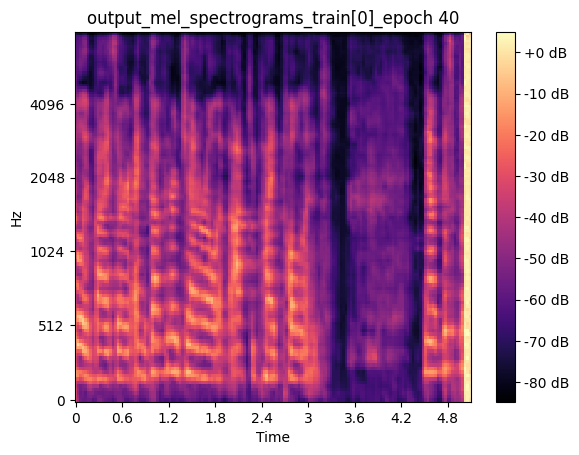

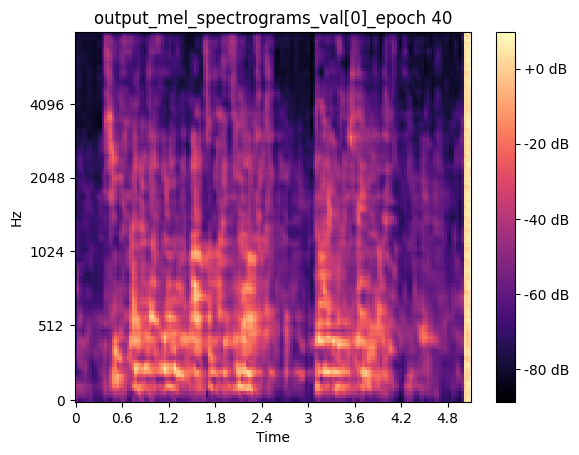

Epoch [41/100], Training Loss: 17.944398880005, Validation Loss: 66.099380493164, Learning Rate: 0.24500000
Epoch [42/100], Training Loss: 17.682769775391, Validation Loss: 62.343311309814, Learning Rate: 0.24500000
Epoch [43/100], Training Loss: 17.344301223755, Validation Loss: 62.820110321045, Learning Rate: 0.24500000
Epoch [44/100], Training Loss: 17.131944656372, Validation Loss: 63.023754119873, Learning Rate: 0.24500000
Epoch [45/100], Training Loss: 16.895292282104, Validation Loss: 62.649345397949, Learning Rate: 0.24500000
Epoch [46/100], Training Loss: 16.644683837891, Validation Loss: 62.951622009277, Learning Rate: 0.24500000
Epoch [47/100], Training Loss: 16.444049835205, Validation Loss: 63.103374481201, Learning Rate: 0.24500000
Epoch [48/100], Training Loss: 16.259366989136, Validation Loss: 63.566352844238, Learning Rate: 0.24500000
Epoch [49/100], Training Loss: 16.128986358643, Validation Loss: 64.812347412109, Learning Rate: 0.24500000
Epoch [50/100], Training Los

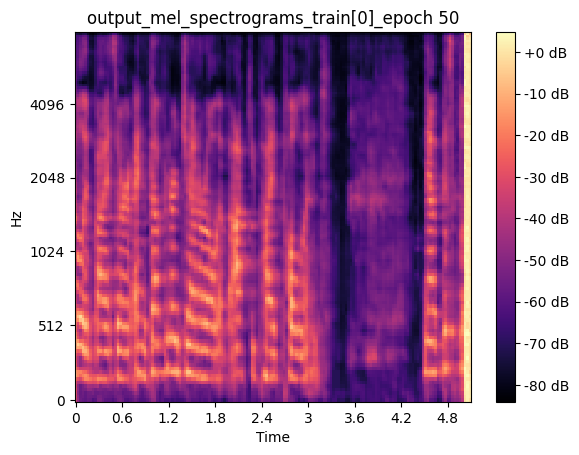

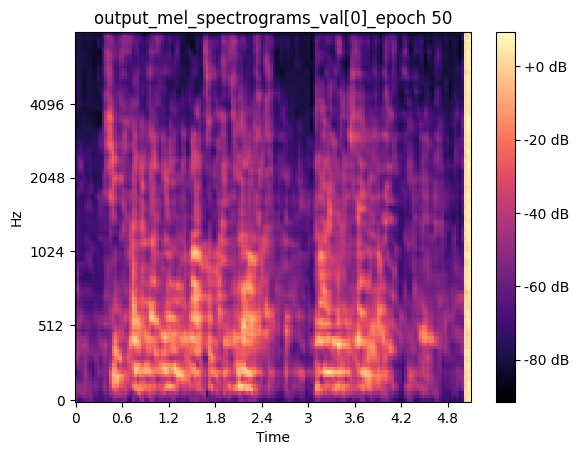

Epoch [51/100], Training Loss: 15.843706130981, Validation Loss: 72.330596923828, Learning Rate: 0.24500000
Epoch [52/100], Training Loss: 15.614272117615, Validation Loss: 72.017013549805, Learning Rate: 0.24500000
Epoch [53/100], Training Loss: 15.525230407715, Validation Loss: 66.126861572266, Learning Rate: 0.24500000
Epoch [54/100], Training Loss: 15.311403274536, Validation Loss: 62.883171081543, Learning Rate: 0.24500000
Epoch [55/100], Training Loss: 15.115270614624, Validation Loss: 63.108886718750, Learning Rate: 0.24500000
Epoch [56/100], Training Loss: 14.947972297668, Validation Loss: 64.417625427246, Learning Rate: 0.24500000
Epoch [57/100], Training Loss: 14.791552543640, Validation Loss: 66.275245666504, Learning Rate: 0.24500000
Epoch [58/100], Training Loss: 14.649436950684, Validation Loss: 67.333015441895, Learning Rate: 0.24500000
Epoch [59/100], Training Loss: 14.523344993591, Validation Loss: 66.642616271973, Learning Rate: 0.24500000
Epoch [60/100], Training Los

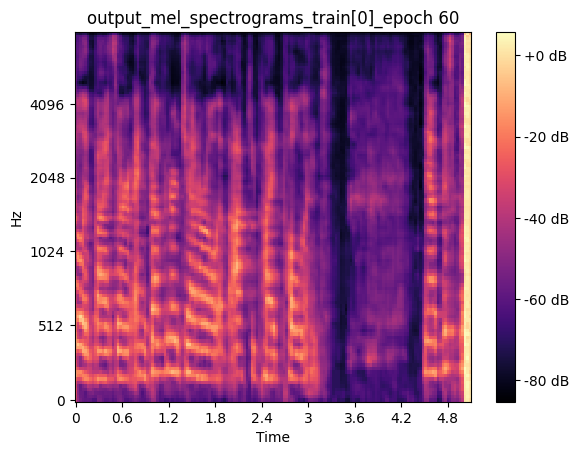

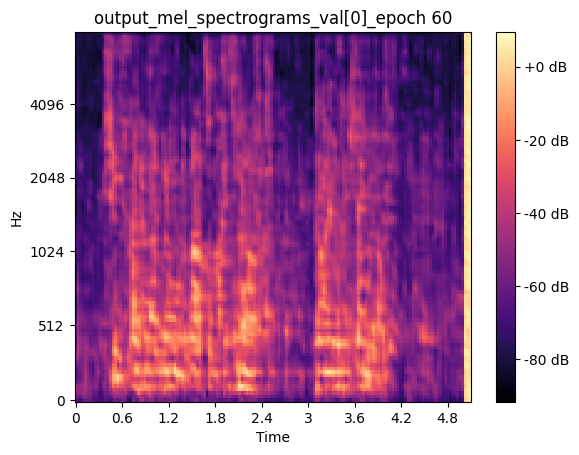

Epoch [61/100], Training Loss: 14.558530807495, Validation Loss: 61.532695770264, Learning Rate: 0.17150000
Epoch [62/100], Training Loss: 14.553068161011, Validation Loss: 60.885948181152, Learning Rate: 0.17150000
Epoch [63/100], Training Loss: 14.392295837402, Validation Loss: 63.041271209717, Learning Rate: 0.17150000
Epoch [64/100], Training Loss: 14.264848709106, Validation Loss: 63.134742736816, Learning Rate: 0.17150000
Epoch [65/100], Training Loss: 13.997441291809, Validation Loss: 62.054157257080, Learning Rate: 0.17150000
Epoch [66/100], Training Loss: 14.128999710083, Validation Loss: 62.116657257080, Learning Rate: 0.17150000
Epoch [67/100], Training Loss: 13.734646797180, Validation Loss: 63.096973419189, Learning Rate: 0.17150000
Epoch [68/100], Training Loss: 13.607114791870, Validation Loss: 63.172538757324, Learning Rate: 0.17150000
Epoch [69/100], Training Loss: 13.512475967407, Validation Loss: 62.630310058594, Learning Rate: 0.17150000
Epoch [70/100], Training Los

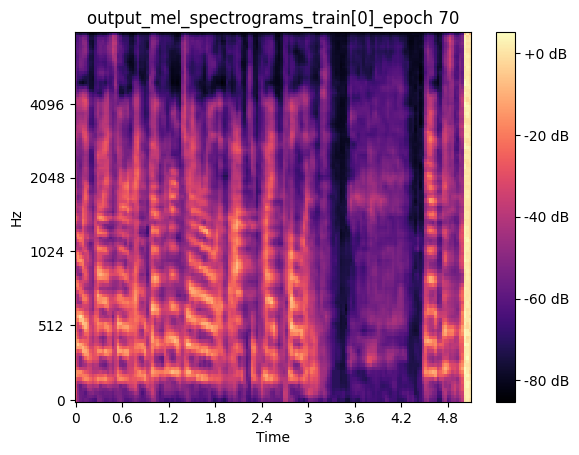

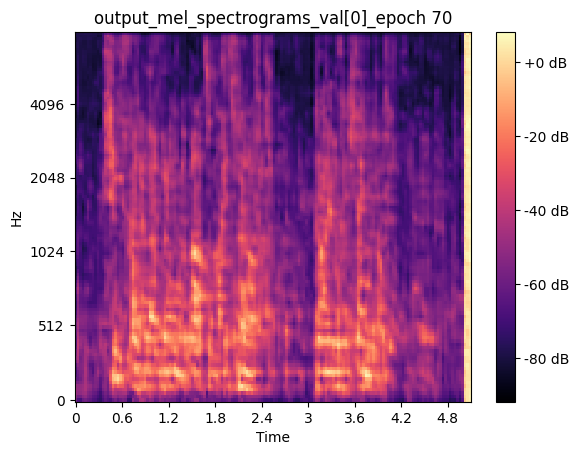

Epoch [71/100], Training Loss: 13.357817649841, Validation Loss: 60.063179016113, Learning Rate: 0.17150000
Epoch [72/100], Training Loss: 13.288881301880, Validation Loss: 58.673900604248, Learning Rate: 0.17150000
Epoch [73/100], Training Loss: 13.225688934326, Validation Loss: 57.724437713623, Learning Rate: 0.17150000
Epoch [74/100], Training Loss: 13.145211219788, Validation Loss: 57.672149658203, Learning Rate: 0.17150000
Epoch [75/100], Training Loss: 13.044919967651, Validation Loss: 58.189990997314, Learning Rate: 0.17150000
Epoch [76/100], Training Loss: 12.975796699524, Validation Loss: 59.930114746094, Learning Rate: 0.17150000
Epoch [77/100], Training Loss: 12.905691146851, Validation Loss: 62.303703308105, Learning Rate: 0.17150000
Epoch [78/100], Training Loss: 12.810617446899, Validation Loss: 62.783611297607, Learning Rate: 0.17150000
Epoch [79/100], Training Loss: 12.748077392578, Validation Loss: 61.904991149902, Learning Rate: 0.17150000
Epoch [80/100], Training Los

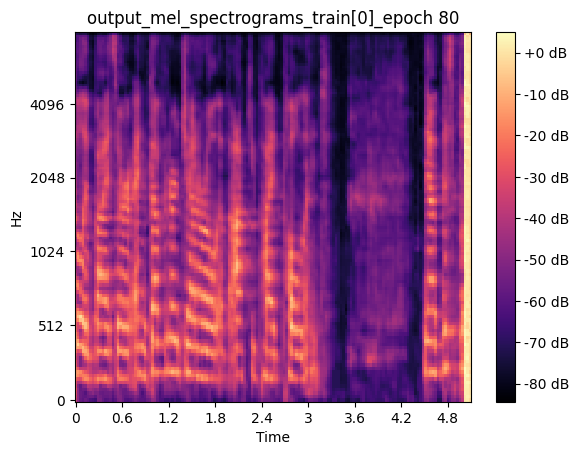

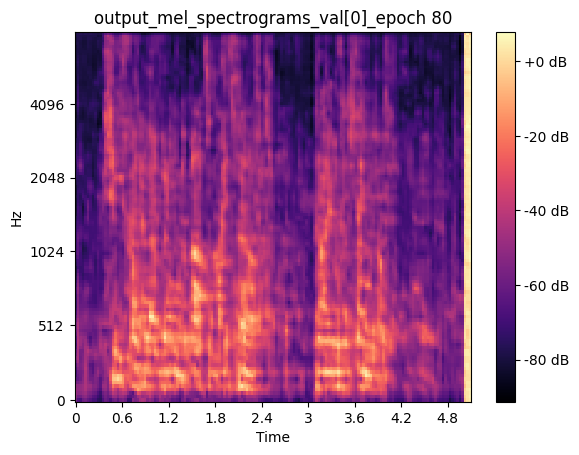

Epoch [81/100], Training Loss: 12.725577354431, Validation Loss: 58.050762176514, Learning Rate: 0.12005000
Epoch [82/100], Training Loss: 12.839056968689, Validation Loss: 57.578636169434, Learning Rate: 0.12005000
Epoch [83/100], Training Loss: 12.878836631775, Validation Loss: 57.590507507324, Learning Rate: 0.12005000
Epoch [84/100], Training Loss: 12.576652526855, Validation Loss: 58.570030212402, Learning Rate: 0.12005000
Epoch [85/100], Training Loss: 12.499175071716, Validation Loss: 57.626075744629, Learning Rate: 0.12005000
Epoch [86/100], Training Loss: 12.408579826355, Validation Loss: 56.643188476562, Learning Rate: 0.12005000
Epoch [87/100], Training Loss: 12.355092048645, Validation Loss: 56.118782043457, Learning Rate: 0.12005000
Epoch [88/100], Training Loss: 12.307774543762, Validation Loss: 56.113319396973, Learning Rate: 0.12005000
Epoch [89/100], Training Loss: 12.256124496460, Validation Loss: 56.547039031982, Learning Rate: 0.12005000
Epoch [90/100], Training Los

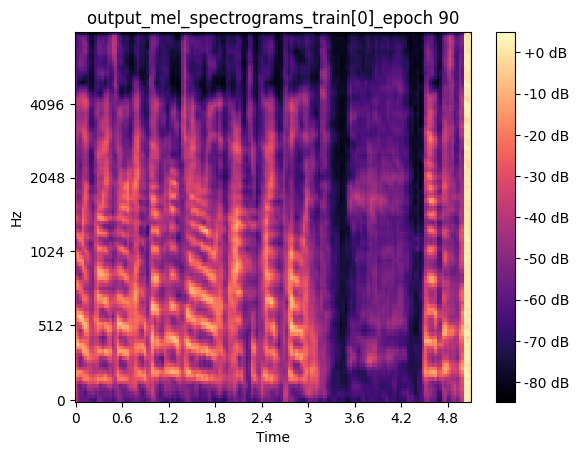

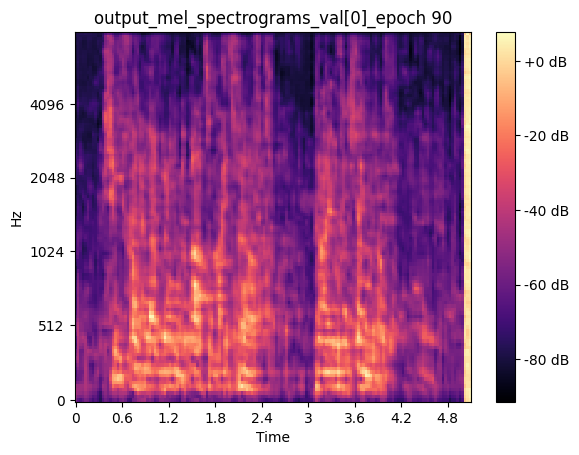

Epoch [91/100], Training Loss: 12.130421638489, Validation Loss: 57.883262634277, Learning Rate: 0.12005000
Epoch [92/100], Training Loss: 12.045284271240, Validation Loss: 58.320915222168, Learning Rate: 0.12005000
Epoch [93/100], Training Loss: 11.982439041138, Validation Loss: 58.370422363281, Learning Rate: 0.12005000
Epoch [94/100], Training Loss: 11.963292121887, Validation Loss: 57.948322296143, Learning Rate: 0.12005000
Epoch [95/100], Training Loss: 11.910818099976, Validation Loss: 57.857940673828, Learning Rate: 0.12005000
Epoch [96/100], Training Loss: 11.826513290405, Validation Loss: 57.628162384033, Learning Rate: 0.12005000
Epoch [97/100], Training Loss: 11.762391090393, Validation Loss: 57.391181945801, Learning Rate: 0.12005000
Epoch [98/100], Training Loss: 11.710400581360, Validation Loss: 57.129119873047, Learning Rate: 0.12005000
Epoch [99/100], Training Loss: 11.662835121155, Validation Loss: 56.912727355957, Learning Rate: 0.12005000
Epoch [100/100], Training Lo

In [12]:
from torch.optim.lr_scheduler import StepLR
import gc
model = DenoiseAutoencoder()

# torchsummary.summary(model,(1,64,44))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)
training_losses = []
validation_losses = []
training_snrs = []
validation_snrs = []
train_input = torch.tensor(np.array([mixed_mel_spectrograms_train[0]]), dtype=torch.float32)
train_clean = torch.tensor(np.array([clean_mel_spectrograms_train[0]]), dtype=torch.float32)
val_input = torch.tensor(np.array([mixed_mel_spectrograms_val[0]]), dtype=torch.float32)
val_clean = torch.tensor(np.array([clean_mel_spectrograms_val[0]]), dtype=torch.float32)

# 訓練過程
for epoch in range(num_epochs):
    model.train()
    sum_loss = 0
    for (mixed, clean) in dataloader:
        
        optimizer.zero_grad()

        # 前向傳播
        outputs = model(mixed)
        loss = criterion(outputs, clean)
        sum_loss += loss.item()
            
        # 反向傳播和優化
        loss.backward()
        optimizer.step()
        
    # Step the scheduler to decay the learning rate
    scheduler.step()
    
    # count training loss and SNR
    snr = calculate_snr(clean, outputs)
    training_losses.append(sum_loss / len(dataloader))
    training_snrs.append(snr)
    
    if epoch % 10 == 0:
        fig, ax = plt.subplots()
        img = librosa.display.specshow(outputs[0][0].detach().cpu().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title=f'output_mel_spectrograms_train[0]_epoch {epoch}')
        plt.show()

        # 將圖像保存至檔案
        output_path = test_dir['visual'] + f'output_mel_spectrograms_train[0]_epoch {epoch}'  # 定義保存的檔案名稱和格式
        fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
        plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())
        gc.collect()
    
    # count validation loss and SNR
    val_output = model(val_input)
    val_loss = criterion(val_output, val_clean)
    val_snr = calculate_snr(val_clean, val_output)
    validation_losses.append(val_loss.item())
    validation_snrs.append(val_snr)
    
    if epoch % 10 == 0:
        fig, ax = plt.subplots()
        img = librosa.display.specshow(val_output[0][0].detach().cpu().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title=f'output_mel_spectrograms_val[0]_epoch {epoch}')
        plt.show()

        # 將圖像保存至檔案
        output_path = test_dir['visual'] + f'output_mel_spectrograms_val[0]_epoch {epoch}'  # 定義保存的檔案名稱和格式
        fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
        plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())
        gc.collect()
    
    # Optionally, print the current learning rate and loss
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.12f}, Validation Loss: {val_loss.item():.12f}, Learning Rate: {current_lr:.8f}")

### Plot Loss

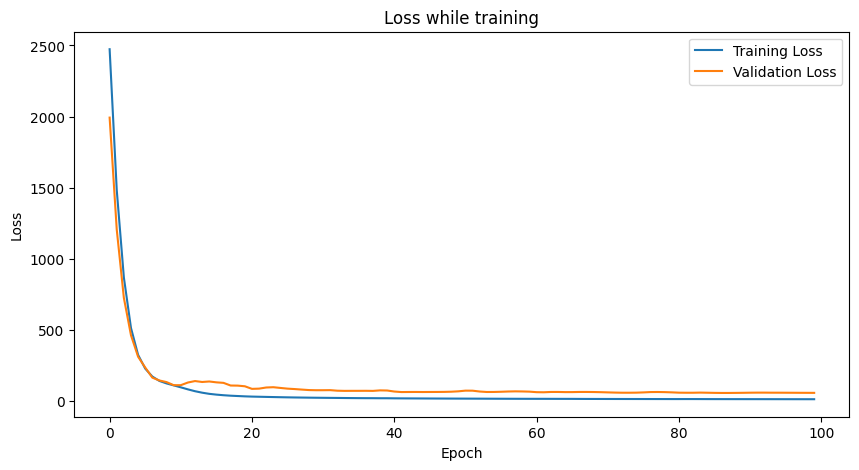

In [13]:
# plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.title("Loss while training")
# plt.xlim([5, num_epochs])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "loss_while_training.png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

### Plot SNR

Training SNR:   26.34948921 dB
Validation SNR: 21.93241119 dB


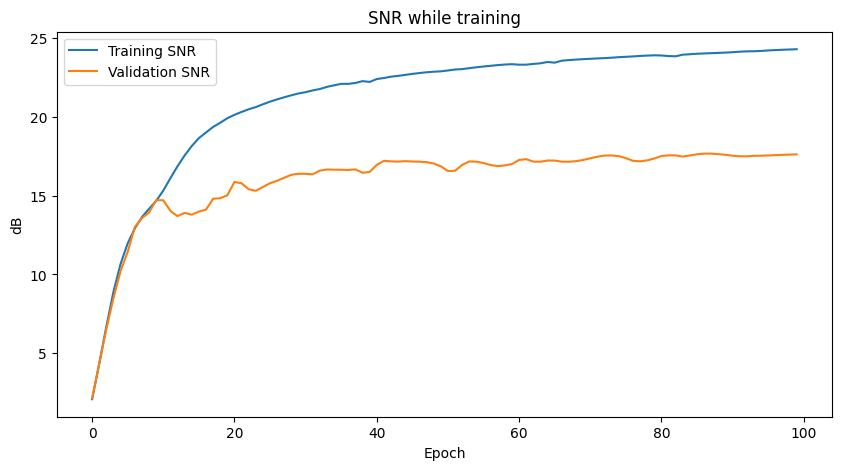

In [14]:
# print the SNR of the first training sample
model.eval()

with torch.no_grad():
    train_output = model(train_input)
    snr = calculate_snr(train_clean, train_output)
    print(f"Training SNR:   {snr:.8f} dB")

with torch.no_grad():
    val_output = model(val_input)
    snr = calculate_snr(val_clean, val_output)
    print(f"Validation SNR: {snr:.8f} dB")
    
# plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_snrs, label="Training SNR")
plt.plot(validation_snrs, label="Validation SNR")
plt.title("SNR while training")
plt.xlabel("Epoch")
plt.ylabel("dB")
plt.legend()
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "snr_while_training.png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像（若不需要可保留 plt.show()）

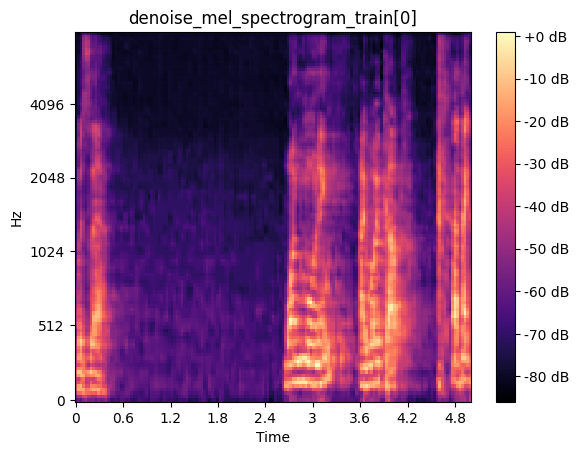

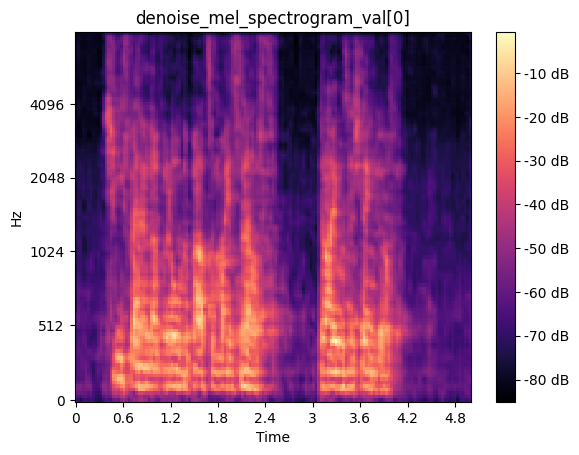

In [15]:
model.eval()

denoised_output = model(torch.from_numpy(mixed_mel_spectrograms_train[0]).unsqueeze(0))
denoised_output = denoised_output[:, :, :, :157]
fig, ax = plt.subplots()
img = librosa.display.specshow(denoised_output.squeeze(0).squeeze(0).detach().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='denoise_mel_spectrogram_train[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "denoise_mel_spectrogram_train[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())

denoised_output = model(torch.from_numpy(mixed_mel_spectrograms_val[0]).unsqueeze(0))
denoised_output = denoised_output[:, :, :, :157]
fig, ax = plt.subplots()
img = librosa.display.specshow(denoised_output.squeeze(0).squeeze(0).detach().numpy(), sr=sample_rate, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='denoise_mel_spectrogram_val[0]')
plt.show()

# 將圖像保存至檔案
output_path = test_dir['visual'] + "denoise_mel_spectrogram_val[0].png"  # 定義保存的檔案名稱和格式
fig.savefig(output_path, dpi=300, bbox_inches='tight')  # dpi 決定解析度，bbox_inches='tight' 防止多餘空白
plt.close(fig)  # 避免顯示圖像 (若不需要可保留 plt.show())

In [16]:
torch.save(model, "machine_model.pth") # TODO

### Prediction

In [17]:
# # MelSpectrogram參數 (勿動)
# n_mels = 128                # 保持 Mel 頻譜圖的解析度
# n_fft = 1024                # 提高 FFT 窗口大小以適配更多信號頻率
# hop_length = 512            # 保持 hop_length 為 n_fft 的一半
# win_length = 1024           # 窗口大小與 n_fft 保持一致（或設為 None 使用默認值）
# sample_rate = 16000         # 採樣率保持不變，適合語音處理
# f_max = sample_rate // 2    # 預設為 Nyquist 頻率，即 8000 Hz
# duration = 5                # 音頻時長為 5 秒

In [18]:
# # MIXED
# mixed_waveform, sample_rate = librosa.load('test2.wav', sr=sample_rate)

# # if sr != sample_rate:
# #     mixed_waveform = librosa.resample(mixed_waveform, orig_sr=sr, target_sr=sample_rate)
    
# # cut to fit the duration
# if len(mixed_waveform) > sample_rate * duration:
#     mixed_waveform = mixed_waveform[:sample_rate * duration]

# mixed_mel_spectrogram = librosa.feature.melspectrogram(
#     y=mixed_waveform,
#     sr=sample_rate,
#     n_fft=n_fft,
#     hop_length=hop_length,
#     n_mels=n_mels
# )

# mixed_mel_spectrogram_db = librosa.power_to_db(
#     mixed_mel_spectrogram, 
#     ref=np.max, 
#     amin=1e-10  # 避免log(0)
# )

# # mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram, dtype=torch.float32).squeeze().unsqueeze(0)
# mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
# # mixed_mel_tensor = torch.tensor(np.load('nature_mixed.npy'), dtype=torch.float32).squeeze().unsqueeze(0)

# mixed_mel = mixed_mel_tensor
# mixed_output = mixed_mel.squeeze(0).squeeze(0).detach().numpy()
# mixed_output = librosa.db_to_power(mixed_output)

# audio_signal = librosa.feature.inverse.mel_to_audio(
#     mixed_output,
#     sr=sample_rate,
#     n_fft=n_fft,
#     hop_length=hop_length,
#     n_iter=512
# )

# audio_signal = audio_signal / np.max(np.abs(audio_signal))


# librosa.display.waveshow(audio_signal, sr=sample_rate)
# soundfile.write('test_librosa_mixed.wav', audio_signal, sample_rate)

In [19]:
# # DENOISED
# model.eval()  # 设置模型为评估模式
# # print(mixed_mel_tensor.shape)
# print(test_mixed_mel_spectrograms[0].shape)
# mixed_mel_np_array = np.array(test_mixed_mel_spectrograms)
# for i in range(len(mixed_mel_np_array)):
#     mixed_mel_np_array[i] = mixed_mel_np_array[i][:, :, :157]
# print(mixed_mel_np_array.shape)

# mixed_mel_tensor = torch.tensor(mixed_mel_np_array, dtype=torch.float32)

# denoised_output = model(mixed_mel_tensor)
# denoised_output = denoised_output[:, :, :, :157]
# print(denoised_output.shape)
# denoised_output = denoised_output.squeeze(0).squeeze(0).detach().numpy()
# denoised_output = librosa.db_to_power(denoised_output)

# audio_signal = librosa.feature.inverse.mel_to_audio(denoised_output, sr=sample_rate, n_iter=500)
# audio_signal = audio_signal / np.max(np.abs(audio_signal))

# librosa.display.waveshow(audio_signal, sr=sample_rate)
# soundfile.write('test_librosa_denoised.wav', audio_signal, sample_rate)
